In [1]:
#Importing necessary libraries
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import random

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Agis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Agis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Agis\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
#Explore data
path = 'Mental_Health_FAQ.csv'
health_data = pd.read_csv(path)

health_data

## NOTE:This dataset is for exploration only and will be converted into JSON file 
##      and then will be manually combined with the main
##      dataset which is 'intents.json' for training


,Question_ID,Questions,Answers
0,1590140,What does it mean to have a mental illness?,Mental illnesses are health conditions that di...
1,2110618,Who does mental illness affect?,It is estimated that mental illness affects 1 ...
2,6361820,What causes mental illness?,It is estimated that mental illness affects 1 ...
3,9434130,What are some of the warning signs of mental i...,Symptoms of mental health disorders vary depen...
4,7657263,Can people with mental illness recover?,"When healing from mental illness, early identi..."
...,...,...,...
93,4373204,How do I know if I'm drinking too much?,Sorting out if you are drinking too much can b...
94,7807643,"If cannabis is dangerous, why are we legalizin...","Cannabis smoke, for example, contains cancer-c..."
95,4352464,How can I convince my kids not to use drugs?,You can't. But you can influence their capacit...
96,6521784,What is the legal status (and evidence) of CBD...,Cannabidiol or CBD is a naturally occurring co...


In [3]:
#Loading the dataset
data = open('intents.json', errors = "ignore")
data_file = data.read()
intents = json.loads(data_file)

In [4]:
words=[]
classes = []
documents = []

for intent in intents['intents']:
    for pattern in intent['patterns']:

        # take each word and tokenize it
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        # adding documents
        documents.append((w, intent['tag']))

        # adding classes to our class list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [5]:
#Lemmatize, lowercase all words, and remove duplicates value
ignore_words = ['?', '!']

words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

classes = sorted(list(set(classes)))

print (len(documents), "documents\n")
print (len(classes), "classes\n", classes, "\n")
print (len(words), "unique lemmatized words\n", words)

pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

145 documents

79 classes
 ['ADHD', 'DID_schizophrenia_difference', 'PTSD', 'PTSD_trauma', 'Social_anxiety', 'adddiction_remedy', 'addiction_causes', 'adult wont help', 'alternative_help', 'antisocial_personality_disorder', 'anxiety', 'anxiety_stress_difference', 'become_involved_treatment', 'binge_eating_disorder', 'causes mental health', 'causes_mental', 'cures for mental health', 'cyclothymic disorder', 'deal telling what to do', 'depression', 'diagnosis', 'difference_mental_health', 'distraction', 'drinking_too_much', 'dysthymia', 'evidence_vaping', 'find_mental_professional_myself', 'funny', 'goodbye', 'greeting', 'grief_loss_stress', 'headache_issues', 'health information good or bad', 'help_alcohol_problem', 'if_support_dont_help', 'information_borderline_personality_disorder', 'involved_treatment', 'keep informed', 'list_of_topic', 'manage', 'mental_health_illness_difference', 'mental_health_pro', 'name', 'no_help', 'noanswer', 'parents has menta illness', 'people_recover_menta

In [6]:
# initializing training data
training = []
output_empty = [0] * len(classes)
for doc in documents:
    # initializing bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")

Training data created


<ipython-input-6-1a891a7a8859>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  training = np.array(training)


In [7]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax

model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

#fitting and saving the model
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)
model.save('NurseBot_model', hist)

print("model created")

Epoch 1/200
29/29 [==============================] - 76s 21ms/step - loss: 4.3561 - accuracy: 0.0078
Epoch 2/200
29/29 [==============================] - 0s 16ms/step - loss: 4.3061 - accuracy: 0.0360
Epoch 3/200
29/29 [==============================] - 0s 12ms/step - loss: 4.2509 - accuracy: 0.0867
Epoch 4/200
29/29 [==============================] - 0s 11ms/step - loss: 4.2194 - accuracy: 0.0633
Epoch 5/200
29/29 [==============================] - 0s 10ms/step - loss: 4.1501 - accuracy: 0.0513
Epoch 6/200
29/29 [==============================] - 0s 15ms/step - loss: 3.9465 - accuracy: 0.1007
Epoch 7/200
29/29 [==============================] - 0s 11ms/step - loss: 3.7572 - accuracy: 0.0556
Epoch 8/200
29/29 [==============================] - 0s 10ms/step - loss: 3.7293 - accuracy: 0.0975
Epoch 9/200
29/29 [==============================] - 0s 10ms/step - loss: 3.5093 - accuracy: 0.1531
Epoch 10/200
29/29 [==============================] - 0s 10ms/step - loss: 3.4107 - accuracy: 0.133

29/29 [==============================] - 0s 16ms/step - loss: 0.6183 - accuracy: 0.8260
Epoch 82/200
29/29 [==============================] - 0s 15ms/step - loss: 0.5563 - accuracy: 0.8691
Epoch 83/200
29/29 [==============================] - 0s 12ms/step - loss: 0.5719 - accuracy: 0.8372
Epoch 84/200
29/29 [==============================] - 0s 12ms/step - loss: 0.7105 - accuracy: 0.8290
Epoch 85/200
29/29 [==============================] - 0s 12ms/step - loss: 0.6259 - accuracy: 0.8761
Epoch 86/200
29/29 [==============================] - 0s 12ms/step - loss: 0.3647 - accuracy: 0.9172
Epoch 87/200
29/29 [==============================] - 0s 12ms/step - loss: 0.4746 - accuracy: 0.8750
Epoch 88/200
29/29 [==============================] - 0s 11ms/step - loss: 0.6014 - accuracy: 0.7917
Epoch 89/200
29/29 [==============================] - 0s 17ms/step - loss: 0.3674 - accuracy: 0.9041
Epoch 90/200
29/29 [==============================] - 1s 16ms/step - loss: 0.4298 - accuracy: 0.8750
Epo

29/29 [==============================] - 0s 11ms/step - loss: 0.2337 - accuracy: 0.9011 0s - loss: 0.1786 - accuracy: 
Epoch 162/200
29/29 [==============================] - 0s 12ms/step - loss: 0.2132 - accuracy: 0.9490
Epoch 163/200
29/29 [==============================] - 0s 10ms/step - loss: 0.2751 - accuracy: 0.8838
Epoch 164/200
29/29 [==============================] - 0s 11ms/step - loss: 0.2558 - accuracy: 0.9238
Epoch 165/200
29/29 [==============================] - 0s 10ms/step - loss: 0.2444 - accuracy: 0.9465
Epoch 166/200
29/29 [==============================] - 0s 10ms/step - loss: 0.2344 - accuracy: 0.9271
Epoch 167/200
29/29 [==============================] - 0s 9ms/step - loss: 0.2651 - accuracy: 0.9024
Epoch 168/200
29/29 [==============================] - 0s 11ms/step - loss: 0.2108 - accuracy: 0.9631
Epoch 169/200
29/29 [==============================] - 0s 10ms/step - loss: 0.2939 - accuracy: 0.9153
Epoch 170/200
29/29 [==============================] - 0s 11ms/ste

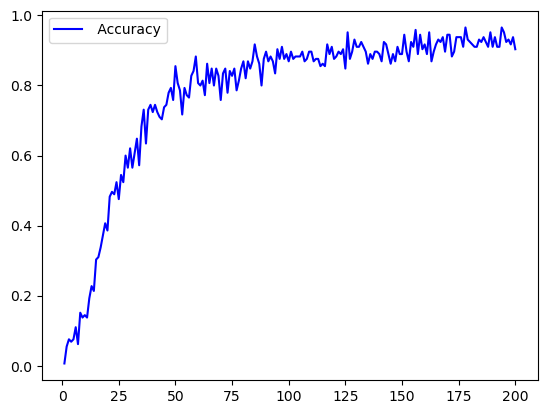

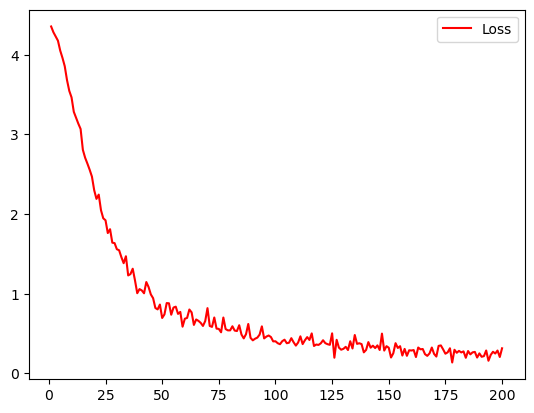

In [8]:
#Accuracy and Loss Plot with matplotlib library
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
loss2 = hist.history['loss']

epochs = range (1,len(acc)+1)

plt.plot(epochs, acc, 'b', label = ' Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss2, 'r', label = 'Loss')
plt.legend()
plt.show()

In [9]:
from keras.models import load_model
model = load_model('NurseBot_model')
import json
import random
intents = json.loads(open('intents.json', errors = "ignore").read())
words = pickle.load(open('words.pkl','rb'))
classes = pickle.load(open('classes.pkl','rb'))

In [10]:
#Create Chatbot Framework in Response Processing
def clean_up_msg(message):
    # ignore punctuation from words
    ignore_words = ['?',',','!','.']
    tokenized_words = nltk.word_tokenize(message)
    clean_words = [lemmatizer.lemmatize(w.lower()) for w in tokenized_words if w not in ignore_words]
    return clean_words

def bow(message, words):
    clean_words = clean_up_msg(message)
    bag = [0] * len(words)
    for clean_word in clean_words:
        for idx, word in enumerate(words):
            if word == clean_word:
                bag[idx] = 1
    return np.array(bag)

def predict_class(message):
    bag_of_words = bow(message, words)
    res = model.predict(np.array([bag_of_words]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[idx, result] for idx, result in enumerate(res) if result > ERROR_THRESHOLD]
    # Sort by Probability
    results.sort(key= lambda x: x[1], reverse= True)
    intent_with_probability = [{'intent': classes[res[0]], 'probabilty' : str(res[1])} for res in results]
    
    return intent_with_probability

def getResponse(ints_with_probability):
    if ints_with_probability and ints_with_probability[0]['probabilty']:
        tag = ints_with_probability[0]['intent']
        list_of_intents = intents['intents']

        for i in list_of_intents:
            if i['tag'] == tag:
                result = random.choice(i['responses'])
                break
        return result

def chatbot_response(msg):
    ints_with_probability = predict_class(msg)
    res = getResponse(ints_with_probability)
    return res

In [11]:
#Creating GUI with tkinter
import tkinter
from tkinter import *


def send():
    msg = EntryBox.get("1.0",'end-1c').strip()
    EntryBox.delete("0.0",END)

    if msg != '':
        ChatLog.config(state=NORMAL)
        ChatLog.insert(END, "You: " + msg + '\n\n')
        ChatLog.config(foreground="white", font=("Verdana", 10 ))

        res = chatbot_response(msg)
        ChatLog.insert(END, "NurseBot: " + res + '\n\n')

        ChatLog.config(state=DISABLED)
        ChatLog.yview(END)


base = Tk()
base.title("NurseBot")
base.geometry("400x500")
base.resizable(width=FALSE, height=FALSE)

#Create Chat window
ChatLog = Text(base, bd=0, bg="#17202A", height="8", width="50", font="Arial",)
ChatLog.config(state=DISABLED)

#Bind scrollbar to Chat window
scrollbar = Scrollbar(base, command=ChatLog.yview, cursor="heart")
ChatLog['yscrollcommand'] = scrollbar.set

#Create Button to send message
SendButton = Button(base, font=("Verdana",10,'bold'), text="Send", width="12", height=5,
                    bd=0, bg="#32de97", activebackground="#3c9d9b",fg='#ffffff',
                    command= send )

#Create the box to enter message
EntryBox = Text(base, bd=0, bg="#2C3E50", fg='#ffffff',width="29", height="5", font="Arial")
#EntryBox.bind("<Return>", send)

#Place all components on the screen
scrollbar.place(x=376,y=6, height=386)
ChatLog.place(x=6,y=6, height=386, width=370)
EntryBox.place(x=128, y=401, height=90, width=265)
SendButton.place(x=6, y=401, height=90)

base.mainloop()


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Agis\anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "<ipython-input-11-a3106c399528>", line 16, in send
    ChatLog.insert(END, "NurseBot: " + res + '\n\n')
TypeError: can only concatenate str (not "NoneType") to str
